# Zonal Average with MOM and POP

Here, we use [xhistogram](https://xhistogram.readthedocs.io/en/latest/) to calculate zonal averages from MOM and POP data!

### Imports

In [11]:
#Import something here
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
import pop_tools
import hvplot
import hvplot.xarray
import geocat.comp

## Read in Data

### POP Dataset

In [12]:
filepath = pop_tools.DATASETS.fetch('cesm_pop_monthly.T62_g17.nc')
pop_ds = xr.open_dataset(filepath)
pop_grid = pop_tools.get_grid('POP_gx1v7')
region_mask = pop_tools.region_mask_3d('POP_gx1v7', mask_name='lat-range-basin')

### MOM Dataset

In [13]:
# Read in the data using xarray or some other package
mom_ds = xr.open_dataset('../data/sample_mom_data.nc')
mom_grid = xr.open_dataset('../data/mom_hybrid_z.003.mom6.static.nc')

### Zonal Average Function

In [14]:
def zonal_average(da_in, grid, lat_axis=None, lat_field='geolat', ydim='yh', xdim='xh', area_field='area_t', region_mask=None):
    """Calculate a zonal average from some model on xarray.DataArray
    
    Parameters
    ----------
    
    da_in : xarray.DataArray
       DataArray to calculate a zonal average from. This should be your data variable
       
    grid : xarray.Dataset
       Grid with the latitude, area field, and latitude axis (if needed), matching dims of da_in
       
    lat_axis : xarray.DataArray
       Latitude axis to use for latitude bins
    
    lat_field : string
       Name of the latitude field to use
    
    ydim : string
       Name of y-dimension
    
    xdim : string
       Name of x-dimension
       
    area_field : string
       Field to use for the area values, used for weighting
       
    Returns
    -------
    da_out : xarray.DataArray
       Resultant zonally averaged field, with the same input name and a new latitude bin axis
    """

    # If not provided a latitude axis, use the y-axis
    if lat_axis is None:
        lat_axis = grid[ydim]
    
    area = grid[area_field].broadcast_like(da_in).where(da_in > -9999)
    lat_2d = grid[lat_field]
    
    if region_mask is not None:
        da_in = da_in.where(region_mask>0)
        area = area * region_mask.where(region_mask>0)
        lat_2d = lat_2d.where(region_mask>0)
    
    # Create the latitude bins using the lat_axis data array
    bins =  np.insert(lat_axis.values, 0, np.array(-90), axis=0)
    
    # Calculate the numerator
    histVolCoordDepth = histogram(lat_2d.broadcast_like(area).where(~np.isnan(area)), bins=[bins], weights=area, dim=[ydim, xdim])
    
    # Calculate the denominator
    histTVolCoordDepth = histogram(lat_2d.broadcast_like(area).where(~np.isnan(area)), bins=[bins], weights=(area*da_in).fillna(0), dim=[ydim, xdim])
    
    da_out = (histTVolCoordDepth/histVolCoordDepth).rename(da_in.name)
    
    # Return the zonal average, renaming the variable to the variable in
    return da_out

In [15]:
mom_ds.FG_CO2.yh.min()

<xarray.DataArray 'yh' ()>
array(-79.20260207)
Attributes:
    long_name:       h point nominal latitude
    units:           degrees_north
    cartesian_axis:  Y

In [16]:
mom_test = zonal_average(mom_ds.FG_CO2, mom_grid)

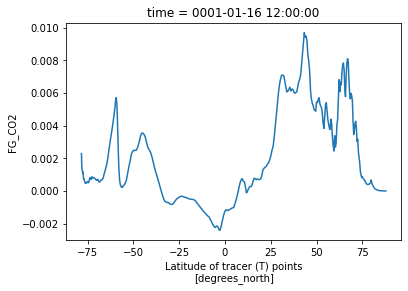

In [17]:
mom_test.plot()

In [18]:
pop_test = zonal_average(pop_ds.TEMP, pop_grid, lat_field='TLAT', area_field='TAREA', ydim='nlat',  xdim='nlon', lat_axis=pop_ds.lat_aux_grid, region_mask=region_mask)

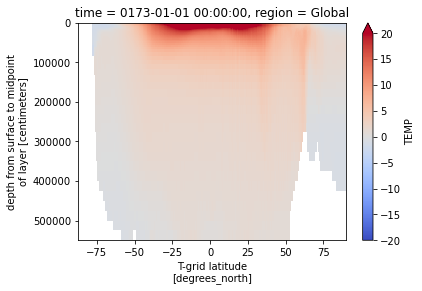

In [27]:
pop_test.isel(region=0).plot(vmin=-20, vmax=20, cmap='coolwarm', yincrease=False)